In [1]:
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from RcTorchPrivate import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

In [2]:
#this method will ensure that the notebook can use multiprocessing on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline

In [3]:
lineW = 3
lineBoxW=2

font = {'family' : 'normal',
        'weight' : 'normal',#'bold',
        'size'   : 22}

#plt.rc('font', **font)
#plt.rcParams['text.usetex'] = True

In [4]:
#helper functions
def pltTr(x,y,clr='cyan', mark='o'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             marker=mark, color=clr, markersize=8, label='truth', alpha = 0.9)

def pltPred(x,y,clr='red', linS='-'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             color=clr, marker='.', linewidth=2, label='RC')
from decimal import Decimal

def convert2pd(tensor1, tensor2):
    pd_ = pd.DataFrame(np.hstack((tensor1.detach().cpu().numpy(), tensor2.detach().cpu().numpy())))
    pd_.columns = ["t", "y"]
    return pd_
'%.2E' % Decimal('40800000000.00000000000000')

def param(t,N,y0):
    f = 1 - torch.exp(-t)
    f_dot = 1 - f
    #f = t
    #f_dot=1
    return y0 + f*N

#define a reparameterization function
def reparam(t, y0 = None, N = None, dN_dt = None, t_only = False):
    f = 1 - torch.exp(-t)
    f_dot = 1 - f
    
    if t_only:
        return f, f_dot

    y = y0 + N*f 
    if dN_dt:
        ydot = dN_dt * f + f_dot * N
    else:
        ydot = None
    return y, ydot

def reparam(t, order = 1):
    exp_t = torch.exp(-t)
    
    derivatives_of_g = []
    
    g = 1 - exp_t
    
    #0th derivative
    derivatives_of_g.append(g)
    
    g_dot = 1 - g
    
    #first derivative
    #derivatives_of_g.append(g_dot)
    
#     for i in range(order):
#         if i %2 == 0:
#             #print("even")
#             derivatives_of_g.append(g_dot)
#         else:
#             #print("odd")
#             derivatives_of_g.append(-g_dot)
#     return derivatives_of_g
    return g, g_dot

def force(X, A = 0):
    return torch.zeros_like(X)

In [5]:
q = 0.5
def custom_loss(X , y, ydot, out_weights, f = force, 
                reg = True, ode_coefs = None, q = q, init_conds = None, enet_strength = None, enet_alpha = None):
    
    #with paramization
    L =  ydot + ode_coefs[0]* y - f(X) + q*y**2
    """
    if reg:
        weight_size_sq = torch.mean(torch.square(out_weights))
        weight_size_L1 = torch.mean(torch.abs(out_weights))
        L_reg = 0.1*(weight_size_sq + weight_size_L1)/2
        L = L + L_reg 
    """
    L = torch.mean(torch.square(L))
    return L

In [6]:
def plot_result(esn, xtrain, lams = [1], y0s = [1], plot_gt = True, loglog = False,
               ode_coefs = None, force_k = 0, fileName=None, q = q,backprop_f = None, time_result = True,
               solve = None):
    
    RC = esn
    fig = plt.figure(figsize = (8, 6))     
    t_pow = 0
    
    gts, ys, ydots, ws, bs, Ls = [], [], [], [], [], []
    
    for i, lam in enumerate(lams):
        y0 = y0s[i]
        ode_coefs[0] = lam
        #fit the echo state network
        
        train_args = {"burn_in" : int(BURN_IN), 
                      "ODE_order" : 1,
                      #"track_in_grad" : self.track_in_grad,
                      "force" : force,
                      "reparam_f" : reparam,
                      #"nl_f" : self.nl_f,
                      "init_conditions" : [float(y0)],
                      "ode_coefs" : ode_coefs,
                      "y" : None,
                      "X" : xtrain.view(-1,1),
                      "q" : q,
                      "nl" : True,
                      

                      }
        
        if not i:
            y, ydot = esn.fit(**train_args, SOLVE = solve)
            
            ode_coefs_copy = ode_coefs.copy()
            states_dict = {"s"  : RC.states.clone(),
                           "s1" : RC.states_dot.clone(), 
                           "G"  : RC.G,
                           "ex" : RC.extended_states.clone(),
                           "sb1": RC.sb1,
                           "sb" : RC.sb
                           }
            if esn.ODE_order == 2:
                            states_dict["s2"] = RC.states_dot2.clone()
                            states_dict["sb2"] = RC.sb2.clone()
            t2 = time.perf_counter()
        else:
            y, ydot = RC.fit(preloaded_states_dict = states_dict, SOLVE = solve,
                            **train_args)
        
        if backprop_f:
            weight_dict = backprop_f(esn)
            y, ydot = esn.fit(**train_args, out_weights = weight_dict, SOLVE = False)
        
        ode_coefs_copy = ode_coefs.copy()
        if ode_coefs[0] == "t**2":
            sp = esn.X**2
            t_pow = 2
            ode_coefs_copy[0] = sp


        def ODE_numSolver(y,t, q = q):
            k = 1
#             dydt = -k * y *t**t_pow + force_k*np.sin(t)
            dydt = -k * y -q*y**2
            return dydt
        y_truth = odeint(ODE_numSolver,y0,np.array(esn.X.cpu().view(-1,)))
        y_truth = torch.tensor(y_truth)
#         y_exac = y0*torch.exp(-lam*(esn.X))
        
        if y0==1:
            extraWidth = 2; color = 'k'
        else: extraWidth=0; color = 'b'
        #line to ensure that cuda tensors can move to cpu for plotti
        X = esn.X.cpu().detach()
        y = y.cpu().detach()
        y_truth = y_truth.cpu().detach()
        if not i:
            plt.plot(X, y,color, linewidth=lineW+extraWidth, label = "pred" )
            plt.plot(X, y_truth,'--r', linewidth=lineW, alpha=0.85, label = "gt")
        else:
            plt.plot(X, y,color, linewidth=lineW+extraWidth)
            plt.plot(X, y_truth,'--r', linewidth=lineW, alpha=0.85)
        
        ## Formating Figure
        # Changing spine style
        ax = plt.gca()
        for ps in ['top','bottom','left','right']:
            ax.spines[ps].set_linewidth(lineBoxW)

        plt.xlabel(r'$t$')
        plt.ylabel(r'$y(t)$')
        plt.legend()
        
        gts.append(y_truth.cpu())
        ys.append(y.cpu())
        ydots.append(ydot.cpu())
        if backprop_f:
            Ls.append(weight_dict["loss"])
        #Ls.append(esn.backprop_args)
        bs.append(esn.LinOut.bias.data.cpu())
        ws.append(esn.LinOut.weight.data.cpu())
    if time_result:
        return t2, ys, ydots, gts, ws, bs, Ls
    else: 
        return ys, ydots, gts, ws, bs, Ls
        
#         plt.savefig(fileName+"Trajectories",format='png')#, dpi=600,transparent=True)
#         plt.savefig(fileName+'Trajectories.eps',format='eps')

#         return residuals
def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 1,
                        epochs = 30000,
                        custom_loss = custom_loss,
                        loss_threshold = 10 ** -8,
                        EPOCHS_TO_TERMINATION = None,
                        f = force,
                        learning_rate = 0.01,
                        plott = True,
                        spikethreshold = 0.25):
    #define new_x
    new_X = esn.extended_states.detach()

    #force detach states_dot
    esn.states_dot = esn.states_dot.detach().requires_grad_(False)

    #define criterion
    criterion = torch.nn.MSELoss()
    
    try:
        assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
    except:
        esn.LinOut.weight.requires_grad_(True)
        esn.LinOut.bias.requires_grad_(True)
    #define previous_loss (could be used to do a convergence stop)
    previous_loss = 0

    #define best score so that we can save the best weights
    best_score = 0

    #define the optimizer
    optimizer = optim.Adam(esn.parameters(), lr = learning_rate)

    #define the loss history
    loss_history = []
    
    if plott:
        #use pl for live plotting
        fig, ax = pl.subplots(1,3, figsize = (16,4))
    
    t = esn.X#.view(*N.shape).detach()
    g, g_dot = esn.G
    y0  = esn.init_conds[0]
    
    #optimizer = torch.optim.SGD(model.parameters(), lr=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    lrs = []
    
    floss_last = 0

    #begin optimization loop
    for e in range(epochs):

        optimizer.zero_grad()
        
        N = esn.forward( esn.extended_states )
        N_dot = esn.calc_Ndot(esn.states_dot)

        y = y0  + g *N 
        
        ydot = g_dot * N + g * N_dot

        assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'
        
        assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        
        assert False, f'{esn.LinOut.weight}'

        total_ws = esn.LinOut.weight.shape[0] + 1
        weight_size_sq = torch.mean(torch.square(esn.LinOut.weight))
        
        loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, reg = False, ode_coefs = esn.ode_coefs)
        loss.backward()
        optimizer.step()
        floss = float(loss)
        loss_history.append(floss)
        
        if not e and not best_score:
            best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()

        if e > SAVE_AFTER_EPOCHS:
            if not best_score:
                
                if floss <= min(loss_history):
                    best_pred = y.clone()
                    best_pred = y.clone()
                    best_ydot = ydot.clone()
                    best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                    best_score = float(loss)
            else:
                if floss < best_score:
                    best_pred = y.clone()
                    best_ydot = ydot.clone()
                    best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                    best_score = float(loss)
                    
        if not EPOCHS_TO_TERMINATION:
            if float(loss) < loss_threshold:
                EPOCHS_TO_TERMINATION = e + 100
        else:
            if e >= EPOCHS_TO_TERMINATION:
                backprop_args = {"loss_history" : loss_history, 
                         "lr" : learning_rate,
                         "epochs" : epochs
                        }
                return {"weights": best_weight, 
                        "bias" : best_bias, 
                        "loss" : backprop_args,
                        "ydot" : best_ydot, 
                        "y" : best_pred}
            
        if e > 1:
            if float(np.log(floss_last) - np.log(floss)) > spikethreshold:
                lrs.append(optimizer.param_groups[0]["lr"])
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print('lr', param_group['lr'])
        floss_last = floss
        if plott:

            if e % 1500 == 0:
                ax[0].clear()
                logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
                delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

                print(logloss_str + ", " + delta_loss)
                ax[0].plot(N.detach().cpu(), label = "exact")
                ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
                ax[0].set_xlabel("epochs")

                ax[1].set_title(delta_loss)
                ax[1].plot(N_dot.detach().cpu())
                #ax[0].plot(y_dot.detach(), label = "dy_dx")
                ax[2].clear()
                weight_size = str(weight_size_sq.detach().item())
                ax[2].set_title("loss history \n and "+ weight_size)

                ax[2].loglog(loss_history)

                [ax[i].legend() for i in range(3)]
                previous_loss = loss.item()

                #clear the plot outputt and then re-plot
                display.clear_output(wait=True) 
                display.display(pl.gcf())
    backprop_args = {"loss_history" : loss_history, 
                         "lr" : learning_rate,
                         "epochs" : epochs
                        }
    return {"weights": best_weight, 
            "bias" : best_bias, 
            "loss" : backprop_args,
            "ydot" : best_ydot, 
            "y" : best_pred}

In [7]:
#optimized_hyper_params

In [8]:
x0,xf, nsteps = 0, 5, 1000 #int(2000 * ratio_up)
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False)

In [9]:
BURN_IN = 500

y0 = 1 ; lam = 1

#the length of xtrain won't matter. Only dt , x0, and xf matter.
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)
xtrain.shape

torch.Size([1000, 1])

In [10]:
#q = 0.7

hybrid_hps_q07 = {'dt': 0.01,
 'n_nodes': 500,
 'connectivity': 0.005200326335063122,
 'spectral_radius': 4.063828945159912,
 'regularization': 0.16819202592057847,
 'leaking_rate': 0.07071314752101898,
 'bias': 0.6888809204101562}


#q = 0.5
########################################################################################

hybrid_hps_q05 = {'dt': 0.007943282347242814,
 'n_nodes': 500,
 'connectivity': 0.0003179179463749722,
 'spectral_radius': 7.975825786590576,
 'regularization': 0.3332787303378571,
 'leaking_rate': 0.07119506597518921,
 'bias': -0.9424528479576111}

########################################################################################


#q = 0.3
########################################################################################
exact_hps_q03 = {'dt': 0.007943282347242814,
 'n_nodes': 500,
 'connectivity': 0.0020952467703604792,
 'spectral_radius': 0.37082985043525696,
 'regularization': 0.361264334627276,
 'leaking_rate': 0.012962563894689083,
 'bias': 0.15055322647094727}

another_exact_03_run = {'dt': 0.007943282347242814,
 'n_nodes': 500,
 'connectivity': 0.00010646483429429022,
 'spectral_radius': 9.755386352539062,
 'regularization': 0.001061326151397624,
 'leaking_rate': 0.015667859464883804,
 'bias': -0.6486743688583374}

# 3000 epochs
hybrid_03_hps = {'dt': 0.007943282347242814,
 'n_nodes': 500,
 'connectivity': 0.000876183849077606,
 'spectral_radius': 7.2928466796875,
 'regularization': 0.6050492589156197,
 'leaking_rate': 0.014219114556908607,
 'bias': 0.18588018417358398}

########################################################################################

#q = 0.1
########################################################################################
#y0s = array([-1.  , -0.25,  0.5 ,  1.25])
hybrid_hyper_params = {'dt': 0.007943282347242814,
 'n_nodes': 500,
 'connectivity': 0.0001340433236446365,
 'spectral_radius': 7.1109442710876465,
 'regularization': 0.0040541553015366605,
 'leaking_rate': 0.022500092163681984,
 'bias': 0.7761751413345337}

exact_hyper_params = {'dt': 0.007943282347242814,
 'n_nodes': 500,
 'connectivity': 0.00457819326682001,
 'spectral_radius': 4.214494228363037,
 'regularization': 672.3718753390342,
 'leaking_rate': 0.11203678697347641,
 'bias': 0.7799162864685059}

########################################################################################


#esn.fit

In [11]:
dRay=0.75
np.arange(-1., 1 + dRay, dRay)

array([-1.  , -0.25,  0.5 ,  1.25])

In [12]:
y0s = np.arange(-1., 1 + dRay, dRay)


dt -2.1
n_nodes 500
connectivity -3.8727548122406006
spectral_radius 7.1109442710876465
regularization -2.392099618911743
leaking_rate 0.022500092163681984
bias 0.7761751413345337

In [13]:
log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt']

hps = {'dt': 0.01,
 'n_nodes': 500,
 'connectivity': 0.0008771738385033052,
 'spectral_radius': 3.8187756538391113,
 'regularization': 2.6243606290132924,
 'leaking_rate': 0.05788800120353699,
 'bias': -0.4182356595993042}

for key, val in hps.items():
    if key in log_vars:
        print(key, np.log10(val))
    else:
        print(key, val)

dt -2.0
n_nodes 500
connectivity -3.0569143295288086
spectral_radius 3.8187756538391113
regularization 0.4190235137939453
leaking_rate 0.05788800120353699
bias -0.4182356595993042


In [14]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-4, -0.1), 
               "spectral_radius" : (1.5, 8.5),
               "n_nodes" : 500,
               "regularization" : (-2, 2),
               "leaking_rate" : (0, 0.1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "dt" : -2,
               "bias": (-1,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            interactive = True, 
                            batch_size = 1, cv_samples = 2, initial_samples = 50,  #200
                            subsequence_length = int(xtrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 10,
                            windowsOS =False, validate_fraction = 0.3, 
                            ODE_order = 1, length_min = 2 **(-7),
                            esn_burn_in = BURN_IN, log_score = True
                            )
#optimize:
opt = False
if opt:
    
    opt_hps = esn_cv.optimize(y = None, x = xtrain,#.cuda(),
                        reparam_f = reparam, 
                        ODE_criterion = custom_loss,
                        init_conditions = [(y0s[0], y0s[-1])], 
                        force = force,
                        rounds = 5,
                        ode_coefs = [1, 1],
                        backprop_f = optimize_last_layer, 
                        solve = False,
                         q = q,
                         n_outputs = 1,
                         eq_system = False,
                         nonlinear_ode = True) #
#

FEEDBACK: None , device: None
cpu


In [15]:
new_prop_hps = {'dt': 0.01,
 'n_nodes': 500,
 'connectivity': 0.001237975145359088,
 'spectral_radius': 5.298933029174805,
 'regularization': 18.616127927682236,
 'leaking_rate': 0.0048981658183038235,
 'bias': -0.40049731731414795}

In [16]:
#opt_hps

In [17]:
#assert False

In [18]:
esn = EchoStateNetwork(**hybrid_hps_q05  , 
                       random_state = 209, 
                       id_ = 10,
                       dtype = torch.float32)

Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =0.00031792.. .regenerating
1 2 

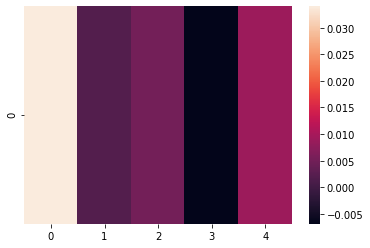

In [19]:
sns.heatmap(esn.LinOut.weight[:,:5].detach());

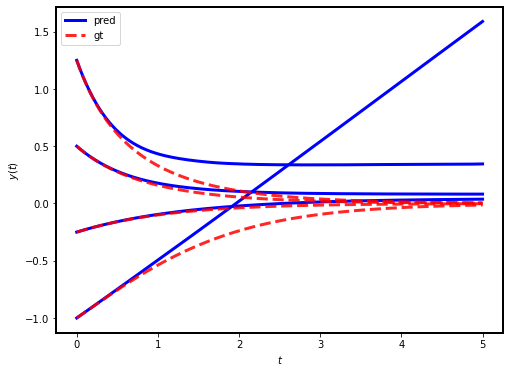

In [34]:
#1. get the linear trajectories

#2. do a pure backprop training
rez = plot_result(esn, xtrain.cpu(), 
            lams = torch.ones_like(torch.tensor(y0s)),#np.array([1] * len(y0s)),#[1, 1, 1, 2]),  
            y0s = y0s, #[1, 2, 3, 1],
            plot_gt = True, 
            ode_coefs = [1,1],
            q = q, 
            backprop_f = None,#optimize_last_layer,
            solve = True)


In [21]:
 esn.init_conds
RC =esn

In [22]:
RC.DH1[0:10,:]

tensor([[ 63.6318,  93.3430, -24.3652,  ...,  63.2987, -23.1793,  63.2987],
        [ 93.3430, 651.7392, 114.2208,  ...,  93.3450, 119.0899,  93.3450],
        [-24.3652, 114.2208,  55.0940,  ..., -24.3648,  55.4541, -24.3648],
        ...,
        [-25.2982, 109.9714,  54.0910,  ..., -25.2978,  54.6943, -25.2978],
        [-48.0399, -78.3725,  16.2769,  ..., -48.0401,  15.3244, -48.0401],
        [-44.0110, -47.2868,  22.0481,  ..., -44.0111,  21.3133, -44.0111]])

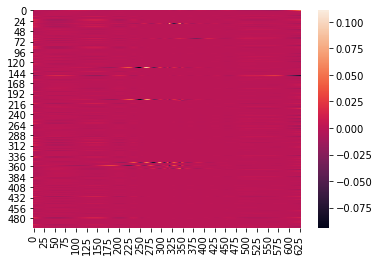

<AxesSubplot:>

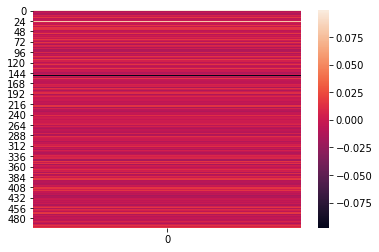

In [23]:
sns.heatmap(RC.DH2); plt.show();
sns.heatmap(matmul(-esn.DH2, esn.D_A).view(-1,1))

In [24]:
esn.init_conds

[-1.0]

<AxesSubplot:>

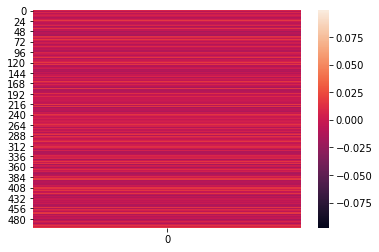

In [25]:
sns.heatmap(esn.LinOut.weight[0].detach().view(-1,1))

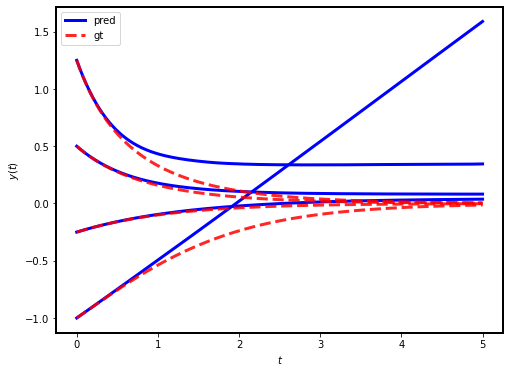

In [26]:
#t2_, ys_, gts_, ws_, bs_, l_trajs = rez
#linear_trajs = 
_, l_trajs, l_trajs_dot, _, _, _, _ = plot_result(esn, xtrain.cpu(), 
            lams = np.array([1] * len(y0s)),#[1, 1, 1, 2]),  
            y0s = y0s, #[1, 2, 3, 1],
            plot_gt = True, 
            ode_coefs = [1,1],
            q = q, 
            backprop_f = None,#optimize_last_layer,
            solve = True)

In [27]:
esn.ode_coefs

[1, 1]

In [28]:
esn.DH2.shape

torch.Size([502, 629])

tensor(2.0312)

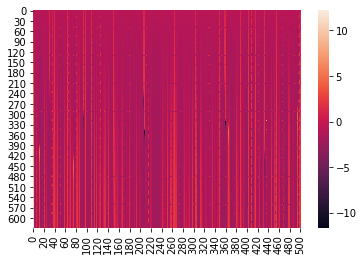

In [29]:
sns.heatmap(esn.DH);
torch.mean(esn.D_A)

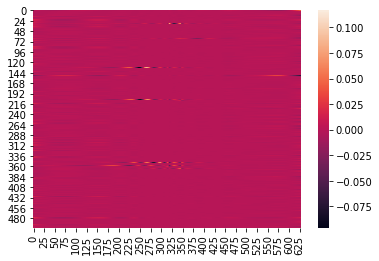

<AxesSubplot:>

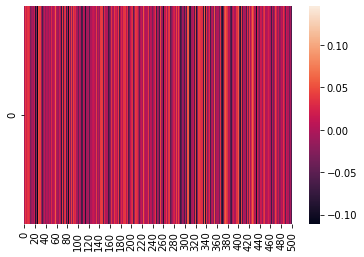

In [30]:
sns.heatmap(esn.DH2);
plt.show();
torch.mean(esn.D_A)
sns.heatmap(esn.LinOut.weight.detach())

<AxesSubplot:>

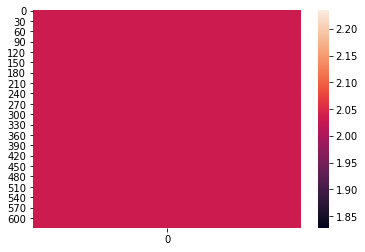

In [31]:
sns.heatmap(esn.D_A)

In [32]:
assert False

AssertionError: 

In [ ]:
t2, ys, ydots, gts, ws, bs, Ls = rez
n = 3
plt.loglog(Ls[n]["loss_history"], label = "prop_only")
#plt.loglog(h["loss"][n]["loss_history"], label = "hybrid")
plt.legend();

In [ ]:
assert False
import pickle
filename = 'bernoulli_q05_hybrid'
with open(filename + '_plot_data_.pickle', 'rb') as handle:
    h = pickle.load(handle)
#filename = 'bernoulli_q05_backprop' 
with open(filename + '_plot_data_.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
with open(filename + '_plot_data_.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
n = 3
plt.loglog(b['loss'][n]["loss_history"], color = "blue", label = "backprop_only")
plt.loglog(h['loss'][n]["loss_history"], color = "red", label = "hybrid")
plt.legend()
# for i, key in enumerate(b['loss']):
#     plt.loglog(key["loss_history"], color = "blue")
# for i, key in enumerate(a['loss']):
#     plt.loglog(key["loss_history"], color = "red")

In [ ]:
assert False

In [ ]:
ls

In [ ]:
import pickle
filename = 'bernoulli_q05_linear'
#t2, ys, ydots, gts, ws, bs, Ls = rez
q05_data = {
#             "time": esn.X, 
#             "ys" : ys,
#             "ydots" : ydots,
#             "gts" : gts,
#             "q": 0.5,
#             "loss": Ls,
            "linear_trajectories" : l_trajs,
            "linear_trajectories_dot" : l_trajs_dot
           }
            #"bprop_only_loss" : Ls_bprop}
with open(filename + '_plot_data.pickle', 'wb') as handle:
    pickle.dump(q05_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(filename + '_plot_data.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
b.keys()

In [ ]:
for i in b['linear_trajectories']:
    plt.plot(i)

In [ ]:
import matplotlib.pyplot as plt
with open(filename + '_plot_data.pickle', 'rb') as handle:
    b = pickle.load(handle)
b.keys()

In [ ]:
plt.plot(b["ydots"][0])

In [ ]:
import pickle

q05 = {"time": esn.X, 
       "hyper_params" : hybrid_hps_q05,
       "out_weights" : {"weights": ws, "bias": bs}, 
       "burn_in" : BURN_IN, 
       "epochs" : 30000,
       "learning_rate": 0.0001,
       "y0s" : y0s,
       "q" : 0.5}

with open(filename + '_reproduce.pickle', 'wb') as handle:
    pickle.dump(q05, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(filename + '_reproduce.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
for param in esn.parameters():
    #print(param)
    if param.requires_grad:
        print(param)

In [ ]:
plot_result(esn, xtrain, lams = np.array([1] * len(y0s)),#[1, 1, 1, 2]),  
            y0s = y0s, #[1, 2, 3, 1],
            lam_title = 1, y0_title = "[-5, 5]", 
            plot_gt = True, ode_coefs = [1,1], 
            force_k = 0, fileName='population', backprop_f = optimize_last_layer,
           q = a)


In [ ]:
opt_hps

In [ ]:
plt.plot(esn.states[:,7])

In [ ]:
correction = (esn.D_A.T * esn.gH.T @ esn.gH)

In [ ]:
esn.DH.shape

In [ ]:
(esn.DH1 + correction).shape

In [ ]:
%%time
esn = EchoStateNetwork(**hybrid_03_hps, 
                       random_state = 109, 
                       feedback = False, 
                       id_ = 10,
                       backprop = False,
                       dtype = torch.float32)
# y0s = np.linspace(-2, 2, 10) 
dRay=0.75
y0s = np.arange(-1., 1 + dRay, dRay)



plot_result(esn, xtrain, lams = np.array([1] * len(y0s)),#[1, 1, 1, 2]),  
            y0s = y0s, #[1, 2, 3, 1],
            lam_title = 1, y0_title = "[-5, 5]", plot_gt = True, ode_coefs = [1,1], 
            force_k = 0, fileName='population',
           backprop_f = optimize_last_layer, q = 0.1)


In [ ]:
%%time
esn = EchoStateNetwork(**hybrid_hyper_params, 
                       random_state = 109, 
                       feedback = False, 
                       id_ = 10,
                       backprop = False,
                       dtype = torch.float32)
# y0s = np.linspace(-2, 2, 10) 
dRay=0.75
y0s = np.arange(-1., 1 + dRay, dRay)
#A * torch.sin(X)

plot_result(esn, xtrain, lams = np.array([1] * len(y0s)),#[1, 1, 1, 2]),  
            y0s = y0s, #[1, 2, 3, 1],
            lam_title = 1, y0_title = "[-5, 5]", plot_gt = True, ode_coefs = [1,1], 
            force_k = 0, fileName='population',
           backprop_f = None)#optimize_last_layer)


In [ ]:
%%time
esn = EchoStateNetwork(**exact_hyper_params, 
                       random_state = 109, 
                       feedback = False, 
                       id_ = 10,
                       backprop = False,
                       dtype = torch.float32)
# y0s = np.linspace(-2, 2, 10) 
dRay=0.75
y0s = np.arange(-1., 1 + dRay, dRay)



plot_result(esn, xtrain, lams = np.array([1] * len(y0s)),#[1, 1, 1, 2]),  
            y0s = y0s, #[1, 2, 3, 1],
            lam_title = 1, y0_title = "[-5, 5]", plot_gt = True, ode_coefs = [1,1], 
            force_k = 0, fileName='population',
           backprop_f = optimize_last_layer, q = 0.1)
